<a href="https://colab.research.google.com/github/10Exahertz/Text-ResNet-on-Sentimental-LIAR-Fake-News/blob/main/Sentimental_LIAR_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is the code for the paper: https://github.com/10Exahertz/Text-ResNet-on-Sentimental-LIAR-Fake-News

Sentimental LIAR: Extended Corpus with ResNet Architecture

The code is for the best performing model where the Statement and Sentiment is passed into ELECTRA-base and the output of the ELECTRA-base is concatenated with Emotion Scores and then passed to the CNN. The model achieved the accuracy of 67.8% with a standard deviation of 1.41% and F1 Macro Score of 62.77% with a standard deviation of 1.41%.

In [ ]:
!pip install -q transformers
!pip install sentencepiece


In [ ]:

import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/train_final.csv")
df_test=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/test_final.csv")
df_valid=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/valid_final.csv")
print("before truncating size of data is :", df.shape, df_test.shape,df_valid.shape)
df=df[:10232] #10208
df_test=df_test[:1264] #1248
df_valid=df_valid[:1280] #1280
print("size of data is :", df.shape, df_test.shape, df_valid.shape)


#check if any null values are present
print("Any null in Subject? ",df['subject'].isnull().values.any())
print("Any null in Speaker? ",df['speaker'].isnull().values.any())
print("Any null in speaker_job? ",df['speaker_job'].isnull().values.any())
print("Any null in Party? ",df['party_affiliation'].isnull().values.any())
print("Any null in Context? ",df['context'].isnull().values.any())


def listV2Out(inputLabel):
  if inputLabel == 'pants-fire':
    return '[1,0,0,0,0]'
  if inputLabel == 'false':
    return '[0,1,0,0,0]'
  if inputLabel == 'barely-true':
    return '[0,0,1,0,0]'
  if inputLabel == 'half-true':
    return '[0,0,0,1,0]'
  if inputLabel == 'mostly-true':
    return '[0,0,0,0,1]'
  if inputLabel == 'true':
    return '[0,0,0,0,1]'
pd.set_option('display.max_columns', None)
df['listV2'] = 0
for i in range(len(df)):
  df.loc[i,'listV2'] = listV2Out(df.loc[i,'label'])
df_test['listV2'] = 0
for i in range(len(df_test)):
  df_test.loc[i,'listV2'] = listV2Out(df_test.loc[i,'label'])
df_valid['listV2'] = 0
for i in range(len(df_valid)):
  df_valid.loc[i,'listV2'] = listV2Out(df_valid.loc[i,'label'])

print("Any null in ListV2? ",df['listV2'].isnull().values.any())


before truncating size of data is : (10236, 31) (1267, 30) (1283, 31)
size of data is : (10232, 31) (1264, 30) (1280, 31)
Any null in Subject?  False
Any null in Speaker?  False
Any null in speaker_job?  True
Any null in Party?  False
Any null in Context?  True
Any null in ListV2?  False


In [ ]:

df['comment_text']=""
df_test['comment_text']=""
df_valid["comment_text"]=""

#combine all the columns into one for train, test and valid data

# df['comment_text']=df['subject'].astype(str)+ ". "+ df["statement"]+\
# df['speaker_id'].astype(str)+". "+df['speaker_job'].astype(str)+". "+ df['party_affiliation'].astype(str)\
# +". "+df['context'].astype(str)+". "+df['sentiment_code'].astype(str)
df['comment_text']= df["statement"]#+". "+df['sentiment_code'].astype(str)

# df_test['comment_text']=df_test['subject'].astype(str)+ ". "+ df_test["statement"]+". "+\
# df_test['speaker_id'].astype(str)+". "+df_test['speaker_job'].astype(str)+". "+ df_test['party_affiliation'].astype(str)\
# +". "+df_test['context'].astype(str)+". "+df['sentiment_code'].astype(str)
df_test['comment_text']= df_test["statement"]#+". "+df_test['sentiment_code'].astype(str)

# df_valid['comment_text']=df_valid['subject'].astype(str)+ ". "+ df_valid["statement"]+\
# df_valid['speaker_id'].astype(str)+". "+df_valid['speaker_job'].astype(str)+". "+ df_valid['party_affiliation'].astype(str)\
# +". "+df_valid['context'].astype(str)+". "+df_valid['sentiment_code'].astype(str)
df_valid['comment_text']= df_valid["statement"]#+". "+df_valid['sentiment_code'].astype(str)


In [ ]:


#concatenate emotion, speakers' credit and sentiment score togehter
df['emotion']="["+df['anger'].astype(str)+","+df['disgust'].astype(str)+","\
+df['fear'].astype(str)+","+df['joy'].astype(str)+","+df['sad'].astype(str) + "," + df['sentiment_score'].astype(str)+"]" #+","+\
# df["barely_true_counts"].astype(str) +","+ df["false_counts"].astype(str)  +","+\
# df["half_true_counts"].astype(str) + ","+df["mostly_true_counts"].astype(str) +","+ \
# df["pants_on_fire_counts"].astype(str)+","+df["sentiment_score"].astype(str)+"]"


df_test['emotion']="["+df_test['anger'].astype(str)+","+df_test['disgust'].astype(str)+","\
+df_test['fear'].astype(str)+","+df_test['joy'].astype(str)+","+df_test['sad'].astype(str) + "," + df_test['sentiment_score'].astype(str)+"]"
# + ","+df_test["barely_true_counts"].astype(str) + ","+ df_test["false_counts"].astype(str) \
# +","+ df_test["half_true_counts"].astype(str) +","+ df_test["mostly_true_counts"].astype(str)\
# +","+ df_test["pants_on_fire_counts"].astype(str)+","+df_test["sentiment_score"].astype(str)+"]"


df_valid['emotion']="["+df_valid['anger'].astype(str)+","+df_valid['disgust'].astype(str)+","\
+df_valid['fear'].astype(str)+","+df_valid['joy'].astype(str)+","+df_valid['sad'].astype(str)+ "," + df_valid['sentiment_score'].astype(str)+"]"
# + ","+df_valid["barely_true_counts"].astype(str) + ","+ df_valid["false_counts"].astype(str) \
# +","+ df_valid["half_true_counts"].astype(str) +","+ df_valid["mostly_true_counts"].astype(str)\
# +","+ df_valid["pants_on_fire_counts"].astype(str)+","+df_valid["sentiment_score"].astype(str)+"]"

In [ ]:
#target should be converted from string to the list
import ast
def convert_to_list(text):
  return ast.literal_eval(text)

In [ ]:
for i in range(len(df["emotion"])):
  try:
    df["emotion"][i]=convert_to_list(df["emotion"][i])
  except:
    print(i,"====",df["emotion"][1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(df_valid["emotion"])):
  try:
    df_valid["emotion"][i]=convert_to_list(df_valid["emotion"][i])
  except:
    print(i,"====",df_valid["emotion"][i], type(df_valid["emotion"][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(df_test["emotion"])):
  try:
    df_test["emotion"][i]=convert_to_list(df_test["emotion"][i])
  except:
    print(i,"====",df_test["emotion"][i], type(df_test["emotion"][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:

df['list']=df['list'].apply(convert_to_list)
df_test['list']=df_test['list'].apply(convert_to_list)
df_valid['list']=df_valid['list'].apply(convert_to_list)

df['listV2']=df['listV2'].apply(convert_to_list)
df_test['listV2']=df_test['listV2'].apply(convert_to_list)
df_valid['listV2']=df_valid['listV2'].apply(convert_to_list)

In [ ]:
#RESNET CODE: Base Class by Frencesco Zuppechini, https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278
#Code was adapted for text based inputs with ELECTRA Embeddings, some changes throughout the architecture were also made, stage sizes and initial CNN layer sizes
 
 
from functools import partial
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, ElectraConfig, ElectraModel, ElectraTokenizer
 
from torch import cuda
 
import torch
import torch.nn as nn
import torch.nn.functional as F
 
from dataclasses import dataclass
from collections import OrderedDict
 
 
 
class Conv1dAuto(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  [self.kernel_size[0] // 2]#, self.kernel_size[0] // 2) # dynamic add padding based on the kernel_size
Kernel_size_main = 3
Gate_k_size = 15
Pool_k_size = 3
 
 
conv1x3 = partial(Conv1dAuto, kernel_size=Kernel_size_main, bias=False) 
#conv = conv1x3(in_channels=32, out_channels=64)
 
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]
 
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
 
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv1x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv1d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm1d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels
 
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm1d(out_channels))
 
 
class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            #nn.Dropout(0.2),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
 
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=Kernel_size_main, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
 
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )
 
    def forward(self, x):
        x = self.blocks(x)
        return x
 
 
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv1d(in_channels, self.blocks_sizes[0], kernel_size=Gate_k_size, stride=1, padding=3, bias=False),
            nn.BatchNorm1d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.AvgPool1d(kernel_size=Pool_k_size, stride=1, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
 
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.maxx = nn.AdaptiveAvgPool1d(1)
        self.decoder = nn.Linear(in_features, n_classes)
 
    def forward(self, x):
        x = self.maxx(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
 
 
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l1 = transformers.ElectraModel.from_pretrained('google/electra-base-discriminator', return_dict = False)
        self.l2 = torch.nn.Dropout(0.2)
        
    def forward(self, ids, mask, token_type_ids,emotion):
        #_, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0]
        output_1 = torch.stack([torch.mean(x,0) for x in output_1])
        output_1 = self.l2(output_1)

        output_1=torch.cat((emotion,output_1),1)
        #print(output_1.size())
        output_1=output_1.unsqueeze(1)
        x = self.encoder(output_1)
        x = self.decoder(x)
        return x
 
def resnet10_3Stage(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2,1,1], *args, **kwargs)

def resnet10_2Stage(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3,1], *args, **kwargs)

def resnet10_1Stage(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[4], *args, **kwargs)

def resnet6(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[1,1], *args, **kwargs)
 
def resnet8(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[1, 1, 1], *args, **kwargs)

def resnet8_2Stage(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2,1], *args, **kwargs)

def resnet8_1Stage(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3], *args, **kwargs)

def resnet10(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[1, 1, 1, 1], *args, **kwargs)
 
def resnet12(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 1, 1, 1], *args, **kwargs)
 
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)
 
def resnet34(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)
 
def resnet50(in_channels, n_classes, block=ResNetBottleNeckBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)
#from torchinfo import summary
 
model = resnet10_3Stage(1, 2)
#summary(model.cuda(), [(1,300),(1,300),(1,300),(1,11)])
sum([param.nelement() for param in model.parameters()])

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


109354818

In [ ]:
 
 
device = 'cuda' if cuda.is_available() else 'cpu'
 
MAX_LEN = 300
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 2
LEARNING_RATE = 1e-05
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
 
#tokenizer.pad_token = tokenizer.eos_token
 
 
 
#torch.manual_seed(0)

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = dataframe.list
        self.max_len = max_len
        #Add emotion list from dataframe
        self.emotion=dataframe.emotion
        self.dfID=dataframe.ID

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'emotion':torch.tensor(self.emotion[index], dtype=torch.float),
            'dfID':self.dfID[index]
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 1
train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=df_test.sample(frac=train_size,random_state=200).reset_index(drop=True)
valid_dataset=df_valid.sample(frac=1,random_state=200).reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
for i in range(len(training_set)):
    sample = training_set[i]
    print(i, sample['ids'].size(), sample['mask'].size(), sample['token_type_ids'].size(), sample['targets'].size(), sample['emotion'].size(), sample['dfID'])

    if i == 3:
        break
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
valid_set= CustomDataset(valid_dataset, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
print(type(df.loc[0,'emotion']))
print(type(df_test.loc[0,'emotion']))
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
valid_loader=DataLoader(valid_set,**test_params)

FULL Dataset: (10232, 34)
TRAIN Dataset: (10232, 34)
TEST Dataset: (1264, 33)
VALID Dataset: (1280, 34)
0 torch.Size([300]) torch.Size([300]) torch.Size([300]) torch.Size([2]) torch.Size([6]) 6564.json
1 torch.Size([300]) torch.Size([300]) torch.Size([300]) torch.Size([2]) torch.Size([6]) 7056.json
2 torch.Size([300]) torch.Size([300]) torch.Size([300]) torch.Size([2]) torch.Size([6]) 11586.json
3 torch.Size([300]) torch.Size([300]) torch.Size([300]) torch.Size([2]) torch.Size([6]) 9707.json
<class 'list'>
<class 'list'>


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv1d(1, 64, kernel_size=(15,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv1dAuto(64, 64, kernel_size=(3,), stride=(1,), padding=[1], bias=False)
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv1dAuto(64, 64, kernel_size=(3,), stride=(1,), padding=[1], bias=False)
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
 
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(params = model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = torch.optim.AdamW(params = model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

In [ ]:
#TRAIN THE MODEL
val_losses=[]
train_losses=[]
accuracy_list=[]
 
for epoch in range(EPOCHS):
  t0 = time.time()
  model.train()
  print(f"\t Epoch: {epoch}  is Started: ")
  batch=0
  train_loss=0
  
  for _,data in enumerate(training_loader, 0):
      try:
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          emotions=data['emotion'].to(device,dtype=torch.float)
      except:
          print(f"some error at testing {batch}")
          print(data['dfID'] )
      try:  
        outputs = model(ids, mask, token_type_ids,emotions)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        train_loss+=loss.item()
        #print(f'{count} Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch+=1
      except EOFError:
        print(f"{data['dfID']} error because of batch size-------->", EOFError)
        print(f"some error at testing {batch}")
        print(data['dfID'] )
  print(f"   Epoch: {epoch} Train loss is :{train_loss/batch}") 
  train_loss /=batch
  train_losses.append(train_loss)    
  print(f"   Epoch {epoch} took: {format_time(time.time() - t0)} \n")
 
  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
      val_loss, batch = 0, 1
      for _, data in enumerate(testing_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          emotions=data['emotion'].to(device,dtype=torch.float)
          batch+=1
          try:
                        outputs = model(ids, mask, token_type_ids,emotions)
                        loss = loss_fn(outputs, targets)
                        val_loss+=loss.item()
                        fin_targets.extend(targets.cpu().detach().numpy().tolist())
                        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
          except:
            print(f"some error at testing {batch}")
            print(data['dfID'] )
 
      val_loss/=batch
      val_losses.append(val_loss)
  outputs=fin_outputs
  outputs = np.array(outputs) >= 0.5
  targets=fin_targets
  accuracy = metrics.accuracy_score(targets, outputs)
  accuracy_list.append(accuracy)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
  print(f"Epoch: {epoch} - Accuracy on Testing Data Score = {accuracy}")
  print(f"Epoch: {epoch} - F1 Score on Testing Data (Micro) = {f1_score_micro}")
  print(f"Epoch: {epoch} - F1 Score on Testing Data (Macro) = {f1_score_macro}")
  print(f"\n \t Epoch {epoch} : Train Loss (Training Data):{train_loss}, Validation Loss (Testing Data): {val_loss}")
  print("_________________________________________________\n")
  #if train_loss > val_loss:
  # torch.save(model.state_dict(), "/content/drive/My Drive/Bibek/models_saved/w9p7")

	 Epoch: 0  is Started: 


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


   Epoch: 0 Train loss is :0.634795990350938
   Epoch 0 took: 0:03:29 

Epoch: 0 - Accuracy on Testing Data Score = 0.6400316455696202
Epoch: 0 - F1 Score on Testing Data (Micro) = 0.6511627906976745
Epoch: 0 - F1 Score on Testing Data (Macro) = 0.6322659084223943

 	 Epoch 0 : Train Loss (Training Data):0.634795990350938, Validation Loss (Testing Data): 0.6196078054560056
_________________________________________________

	 Epoch: 1  is Started: 
   Epoch: 1 Train loss is :0.5906110264017211
   Epoch 1 took: 0:03:29 

Epoch: 1 - Accuracy on Testing Data Score = 0.6613924050632911
Epoch: 1 - F1 Score on Testing Data (Micro) = 0.6650868878357029
Epoch: 1 - F1 Score on Testing Data (Macro) = 0.6337414214558211

 	 Epoch 1 : Train Loss (Training Data):0.5906110264017211, Validation Loss (Testing Data): 0.5934983098282004
_________________________________________________



In [ ]:
from pandas import DataFrame
df=DataFrame(train_losses,columns=['train_losses'])
df=DataFrame(val_losses,columns=['val_losses'])
df.to_csv("/content/drive/My Drive/Bibek/Results/w10_p4.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


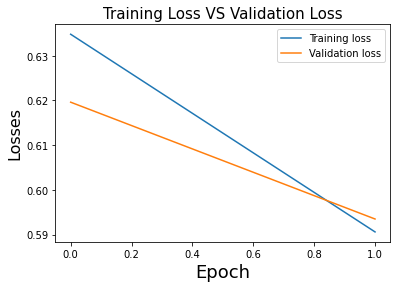

In [ ]:

import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")

plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Losses', fontsize=16)
plt.title('Training Loss VS Validation Loss', fontsize=15)

plt.legend()
plt.savefig('/content/drive/My Drive/Bibek/w10_p4-epoch1.eps')

#plt.title("Losses")
#ResNet10, 5 epochs

In [ ]:
model.eval()
fin_targets=[]
fin_outputs=[]
with torch.no_grad():
    c=0
    for _, data in enumerate(valid_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        emotions=data['emotion'].to(device,dtype=torch.float)
        c+=1
        try:
                      outputs = model(ids, mask, token_type_ids,emotions)
                      fin_targets.extend(targets.cpu().detach().numpy().tolist())
                      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        except EOFError:
          print(f"some error at {c}",EOFError)
outputs=fin_outputs
outputs = np.array(outputs) >= 0.5
targets=fin_targets
accuracy = metrics.accuracy_score(targets, outputs)
 
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Epoch:  {epoch}, Accuracy Score on validation data = {accuracy}")
 
print(f"Epoch:  {epoch}, F1 Score on Validation Data (Macro) = {f1_score_macro}") 
print("____________________________________________________________\n________________________________________________________________\n\n")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch:  1, Accuracy Score on validation data = 0.6796875
Epoch:  1, F1 Score on Validation Data (Macro) = 0.6324548825710754
____________________________________________________________
________________________________________________________________




In [ ]:
df_demo=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/Demo.csv")
df_demo['comment_text']=""
df_demo['comment_text']= df_demo["statement"]+". "+df_demo['sentiment_code'].astype(str)

df_demo['emotion']="["+df_demo['anger'].astype(str)+","+df_demo['disgust'].astype(str)+","\
+df_demo['fear'].astype(str)+","+df_demo['joy'].astype(str)+","+df_demo['sad'].astype(str) + "]"
for i in range(len(df_demo["emotion"])):
  try:
    df_demo["emotion"][i]=convert_to_list(df_demo["emotion"][i])
  except:
    print(i,"====",df_demo["emotion"][1])

df_demo['list']=df_demo['list'].apply(convert_to_list)


demo_set = CustomDataset(df_demo, tokenizer, MAX_LEN)

demo_params = {'batch_size': 8,
                'shuffle': False,
                'num_workers': 0
                }
demo_loader = DataLoader(demo_set, **demo_params)


with torch.no_grad():
    c=0
    for _, data in enumerate(demo_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        emotions=data['emotion'].to(device,dtype=torch.float)
        c+=1
        try:
                      outputs = model(ids, mask, token_type_ids,emotions)
                      fin_targets.extend(targets.cpu().detach().numpy().tolist())
                      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                      print(torch.sigmoid(outputs))
                      # print(emotions)


        except EOFError:
          print(f"some error at {c}",EOFError)


tensor([[0.3571, 0.6562],
        [0.3571, 0.6562],
        [0.4887, 0.5302],
        [0.4402, 0.5721],
        [0.2100, 0.8025],
        [0.2806, 0.7300],
        [0.3925, 0.6204],
        [0.1871, 0.8221]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
